In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from src.utils_py.io.gro import read_gro, write_gro
from circle_fit import taubinSVD
from hyperopt import fmin, tpe, hp, Trials
from tqdm import tqdm
import MDAnalysis as mda

/Users/alexey/Dev/CA_project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

In [11]:
def y_approx(zeta, l, phi, theta):
    if np.abs(theta - np.pi / 2) < 0.5:
            return (phi * l - (1 - 120 * zeta**2 + 720 * zeta**4) * (theta - np.pi / 2)**3 / 360 - (12 * zeta**2 - 1) * (theta - np.pi / 2) / 6) / 2

    return (phi * l - (2 * theta - np.pi) / 4 / np.cos(theta)**2 + np.sign(2 * theta - np.pi) * np.sqrt(1 / np.cos(theta)**2 - 4 * zeta**2) + np.tan(theta) / 2) / 2

In [12]:
def get_center_pbc(positions, box):
    theta = positions / box * 2 * np.pi
    center = np.zeros(3)

    for i in range(3):
        phi = np.cos(theta[:, i])
        psi = np.sin(theta[:, i])

        phi_mean = np.average(phi)
        psi_mean = np.average(psi)

        theta_mean = np.arctan2(-psi_mean, -phi_mean) + np.pi
        center[i] = box[i] * theta_mean / 2 / np.pi

    return center

In [13]:
def apply_pbc(positions, box):
    half_box_size = box / 2

    ids = abs(positions - half_box_size) >= half_box_size
    positions -= np.sign(positions) * box * ids

    return positions

In [14]:
def center_residue(AtomGroup, box):
    positions = AtomGroup.copy().positions
    center = get_center_pbc(positions, box)
    positions -= center
    positions += box / 2

    return apply_pbc(positions, box)

In [15]:
def density_plane(universe, residue_name, M, center=True, begin=0):
    u = universe.copy()
    residue = u.select_atoms(f'resname {residue_name}', updating=True)
    box = u.dimensions[:3] * 0.1 #nm
    traj = u.trajectory[begin:]
    N = len(traj)
    axis_x, dx = np.linspace(0, box[0], M, retstep=True)
    axis_z, dz = np.linspace(0, box[2], M, retstep=True)
    dr = np.array([dx, dz])
    data = np.zeros((N, M, M), dtype=np.float32)

    for ts in tqdm(traj):
        residue.positions *= 0.1
        if center:
            residue.positions = center_residue(residue, box)

        residue_ids = np.floor(residue.positions[:, ::2] / dr).astype(int)
        residue_ids -= (residue_ids == M)

        for id in residue_ids:
            data[ts.frame-begin, id[0], id[1]] += 1

    data = np.mean(data, axis=0)

    return axis_x, axis_z, data / (dx * dz * box[0]), dx, dz

In [16]:
def get_border(grid, min=3, max=7):
    border = np.zeros_like(grid)
    shape = grid.shape

    for (i, j) in np.ndindex((shape[0]-2, shape[1]-2)):
        # neigh = (grid[i-1, j+1] > 0) + (grid[i, j+1] > 0) + (grid[i+1, j+1] > 0) + \
        #         (grid[i-1, j] > 0)   +                    + (grid[i+1, j] > 0) + \
        #         (grid[i-1, j-1] > 0) + (grid[i, j-1] > 0) + (grid[i+1, j-1] > 0)

        # neigh_list = np.array([grid[i-1, j+1], grid[i, j+1], grid[i+1, j+1], grid[i-1, j], grid[i+1, j], grid[i-1, j-1], grid[i, j-1], grid[i+1, j-1]])
        neigh_list = np.array([grid[i, j], grid[i+1, j], grid[i+2, j], grid[i, j+1], grid[i+2, j+1], grid[i, j+1], grid[i+1, j+1], grid[i+2, j+1]])
        neigh = np.sum(neigh_list > 0)

        if min <= neigh <= max:
            border[i, j] = 1

    return border

In [17]:
def remove_hlines(border, max_sum=10):
    # return border * ((np.sum(border[:border.shape[0]//2, :], axis=0) <= max_sum) + (np.sum(border[border.shape[0]//2:, :], axis=0) <= max_sum))
    return border * (np.sum(border, axis=0) <= max_sum)
    # return new_border

In [18]:
def get_points_from_border(border):
    points = list()

    for (i, j) in np.ndindex(border.shape):
        if border[i, j]:
            points.append(np.array([i, j]))

    return np.array(points)

In [19]:
def points2xyz(points_grid, dr, box):
    points = np.zeros_like(points_grid, dtype=np.float64)
    for i in range(points_grid.shape[0]):
        points[i, :] = (points_grid[i, :] + 0.5) * dr
    
    return points - box / 2

In [38]:
approx = []

u = mda.Universe(
    'data/cal_x1.gro',
    'data/cal_x1.xtc'
)

In [39]:
x, z, grid, dx, dz = density_plane(u, 'DECAN', 150, begin=500, center=True)

100%|██████████| 4415/4415 [00:44<00:00, 98.26it/s] 


100%|██████████| 2000/2000 [00:08<00:00, 225.83trial/s, best loss: 0.007856656276995926]
Best right
angle: 104.7
offset: -0.02

Best left
angle: 99.9
offset: -0.07
------------------------------
Mean angle: 102.3


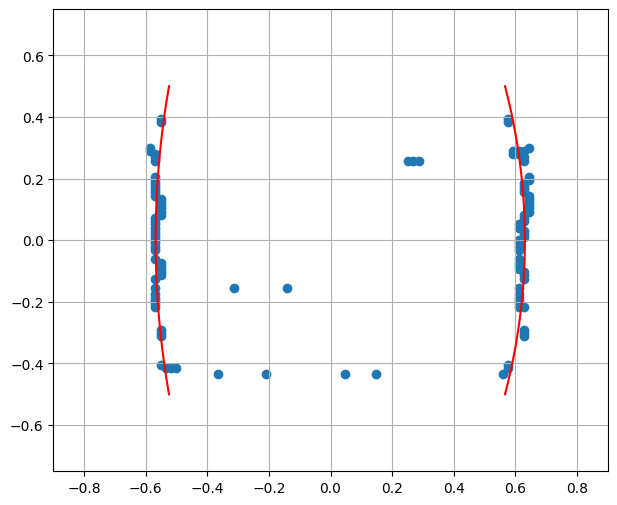

In [40]:
grid_filter = (grid > 15) * grid
border = get_border(grid_filter, min=5, max=7)
border = remove_hlines(border, max_sum=5)

H = 3.928
points = get_points_from_border(border)
points_xyz = points2xyz(points, np.array([dx, dz]), u.dimensions[1:3] * 0.1)
points_xyz /= H

right_points, left_points = [], []

for point in points_xyz:
    if point[0] >= 0.5:
        right_points.append(point)
    elif point[0] <= -0.5:
        left_points.append(point)

right_points = np.array(right_points)
left_points = np.array(left_points)

def error_right(args):
    return np.sum((y_approx(right_points[:, 1], 2.5, 0.5, args['theta']) + args['offset'] - right_points[:, 0])**2)

def error_left(args):
    return np.sum((y_approx(left_points[:, 1], 2.5, 0.5, args['theta']) + args['offset'] + left_points[:, 0])**2)

trials_right = Trials()
trials_left = Trials()

space = {
    'theta': hp.uniform('theta', 0, np.pi),
    'offset': hp.uniform('offset', -1, 1)
}

best_right = fmin(
    fn=error_right,
    space=space,
    algo=tpe.suggest,
    max_evals=2000,
    trials=trials_right,
    show_progressbar=True
)

best_left = fmin(
    fn=error_left,
    space=space,
    algo=tpe.suggest,
    max_evals=2000,
    trials=trials_left,
    show_progressbar=True
)

print('Best right')
print('angle:', '{:.1f}'.format(np.rad2deg(best_right['theta'])))
print('offset:', '{:.2f}'.format(best_right['offset']))
print()

print('Best left')
print('angle:', '{:.1f}'.format(np.rad2deg(best_left['theta'])))
print('offset:', '{:.2f}'.format(best_left['offset']))
print('------------------------------')

print('Mean angle: {:.1f}'.format(np.rad2deg(best_left['theta'] + best_right['theta']) / 2))

approx.append([best_left['theta'], best_right['theta']])

plt.figure(figsize=(8, 6))

plt.grid()
plt.scatter(points_xyz[:, 0], points_xyz[:, 1])
z = np.linspace(-0.5, 0.5, 100)
plt.plot(y_approx(z, 2.5, 0.5, best_right['theta']) + best_right['offset'], z, color='red')
plt.plot(-y_approx(z, 2.5, 0.5, best_left['theta']) - best_left['offset'], z, color='red')

plt.xlim(-0.9, 0.9)
plt.ylim(-0.75, 0.75)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

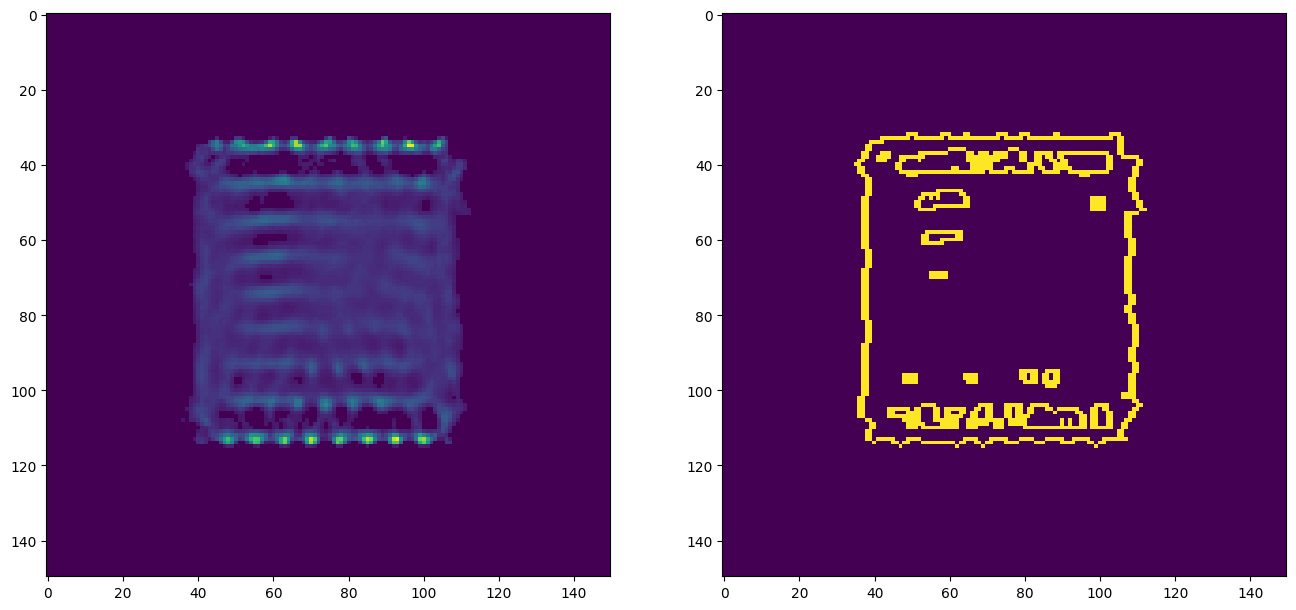

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(16, 12))

grid_filter = (grid > 15) * grid
border = get_border(grid_filter, min=3, max=7)

ax[0].imshow(grid_filter.T)
ax[1].imshow(border.T)

In [42]:
2*np.sqrt(9*np.pi/8)

3.7599424119465006

In [43]:
2*1.5*1.5

4.5

In [45]:
1-100/120

0.16666666666666663